In [1]:
import data_utils
import layers

ImportError: No module named data_utils

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import layers
from data_utils import load_CIFAR10
'''
# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'spline16'
plt.rcParams['image.cmap'] = 'gray'
'''

# Reload external python modules;Autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
np.set_printoptions(formatter={'all': lambda x: "%.2f" % x})

# Linear Classification

## Machine Learning Key Ingredients
Any machine learning algorithm is composed of **four key ingredients**: 
- **Data** (Trainig, Test, Validation)
- **Model** or algorithm (Linear, Logistic Regression, Neural Network, Support Vector Machine, etc.)
- **Loss function** (Cross-Enropy, multi-class SVM, SSE, etc.)
- **Optimization method** (Gradient Descent, Mini-batch Gradient Decsent, Adam, RMSprops, etc.)

## Objectives
- Linear Classification
- Loss Functions
 - Multi-class SVM Loss function (hinge loss)
 - Multi-class Logistic Regression loss function (cross-entopy or softmax)
- Optimization
- Gradient Descent Algorithm

## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
import data_utils
from data_utils import load_CIFAR10
import layers
cifar10_dir = './datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape:   ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape:       ', X_test.shape)
print('Test labels shape:     ', y_test.shape)

('Training data shape:   ', (50000, 32, 32, 3))
('Training labels shape: ', (50000,))
('Test data shape:       ', (10000, 32, 32, 3))
('Test labels shape:     ', (10000,))


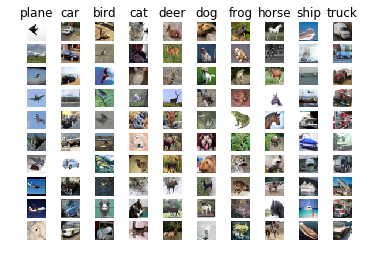

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape:        ', X_train.shape)
print('Train labels shape:      ', y_train.shape)
print('Validation data shape:   ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape:         ', X_test.shape)
print('Test labels shape:       ', y_test.shape)

('Train data shape:        ', (49000, 32, 32, 3))
('Train labels shape:      ', (49000,))
('Validation data shape:   ', (1000, 32, 32, 3))
('Validation labels shape: ', (1000,))
('Test data shape:         ', (1000, 32, 32, 3))
('Test labels shape:       ', (1000,))


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape:   ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape:       ', X_test.shape)
print('dev data shape:        ', X_dev.shape)

('Training data shape:   ', (49000, 3072))
('Validation data shape: ', (1000, 3072))
('Test data shape:       ', (1000, 3072))
('dev data shape:        ', (500, 3072))


[130.64 135.98 132.47 130.06 135.35 131.75 130.96 136.14 132.48 131.48]


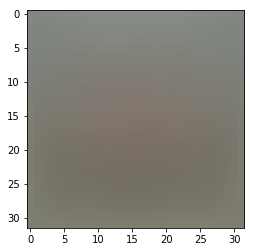

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [9]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val   -= mean_image
X_test  -= mean_image
X_dev   -= mean_image

## Parametric Classification
- In any parametric method, there are a **fixed set of parameters**.
- The goal of learning is to **determine the best possible values** for these parameters.
- After learning parameters from data, we can predict for new data **using only these parameters**.

## Score function
Earlier, we said that in supervised learning, we have a training dataset such as:

$$\{(x^{(1)}, y^{(1)}),(x^{(2)}, y^{(2)}),\dots,(x^{(N)}, y^{(N)})\}$$

and, we are looking for a function (hypothesis) from input features to the target values, as following:

$$h: X \to Y $$

Here, our approach will have two major components: 
- a **score function** that maps the raw data to class scores, and
- a **loss function** that quantifies the agreement between the predicted scores and the ground truth labels. 

We will then cast this as an optimization problem in which we will minimize the loss function with respect to the parameters of the score function.

### Linear score function

**Linear classifier.** 
- We will start out with the simplest possible function, a linear mapping:

$$f(x_i,W,b)=Wx_i+b$$

**Assumptions.**
- The image $x_i$ has all of its pixels flattened out to a single column vector of shape [D x 1]. 
- The matrix W (of size [K x D]), and the vector b (of size [K x 1]) are the parameters of the function. 

**Example.**
- In CIFAR-10, $x_i$ contains all pixels in the i-th image flattened into a single [3072 x 1] column, 
- W is [10 x 3072] and b is [10 x 1], 
- So, 3072 numbers come into the function (the raw pixel values) and 10 numbers come out (the class scores). 

The parameters in W are often called the **weights**, and b is called the **bias** vector because it influences the output scores, but without interacting with the actual data $x_i$. 

<div class="alert alert-warning">
    <b>Quetion?</b>
    <ul>
        <li> Considering the below figure, are the given values for the parameters are good values?
        </li>
    </ul>
</div>

#### Bias trick

<img src="http://www.snrazavi.ir/imgs/wb.jpeg" width="80%"/>

## Geometric Interpretation

**Analogy of images as high-dimensional points.** 
- Since the images are stretched into high-dimensional column vectors, we can interpret each image as a single point in this space.
- For example, each image in CIFAR-10 is a point in 3072-dimensional space of 32x32x3 pixels.

**Geometric interpretation.**
- Every row of $W$ is a classifier for one of the classes (a *hyper-plane*).
- As we change one of the rows of $W$, the corresponding line in the pixel space will rotate in different directions. 
- The biases $b$, allow our classifiers to translate the lines. 

## Linear Classification: Another Interpretation

<img src="http://www.snrazavi.ir/imgs/LinearClassification_prototypes.png" width="100%"/>

**Interpretation of linear classifiers as template matching.**
- Another interpretation: each row of $W$ corresponds to a **template** (or *prototype*) for one of the classes. 
- Inner product: the score of each class for an image is then obtained by comparing each template with the image using an **inner product** (or *dot product*) one by one to find the one that “fits” best. 
- With this terminology, the linear classifier is doing **template matching**, where the templates are learned. 

## Defining a Linear Layer: Forward Step

In [10]:
def affine_forward(x, W, b):
    """
    A linear mapping from inputs to scores.
    
    Inputs:
        - x: input matrix (N, d1, d2, ...dn)
        - W: weigh matrix (D, C)
        - b: bias vector  (C, )
    
    Outputs:
        - out: output of linear layer (N, C)
    """
    x2d = np.reshape(x, (x.shape[0], -1))  # convert 4D input matrix to 2D    
    out = np.dot(x2d, W) + b               # linear transformation
    cache = (x, W, b)                      # keep for backward step (stay with us)
    return out, cache

# Loss Function

**Loss Function.** (sometimes called *cost* function or *objective*)
- A measure which tells the machine how much the current parameters are bad.
- Intuitively, the loss will be high if the parameters are doing a poor job of classifying the training data, and it will be low if they are doing well.

<img src="http://www.snrazavi.ir/imgs/loss.png" width="60%"/>

## Multi-class SVM Loss Function

Computing loss for a single training data $(x_i, y_i)$.

We want ($\forall j \ne y_i$):

### $$s_{y_i} \ge s_j+1$$

or, equivlently:

### $$s_j - s_{y_i} + 1 \le 0$$


#### Margins

<img src="http://www.snrazavi.ir/imgs/margin.jpg" width="60%"/>

### Unvectorized implementation

In [11]:
def L_i(x, y, W):
    """
    unvectorized version. Compute the multiclass svm loss for a single example (x,y)
    - x is a column vector representing an image (e.g. 3073 x 1 in CIFAR-10)
      with an appended bias dimension in the 3073-rd position (i.e. bias trick)
    - y is an integer giving index of correct class (e.g. between 0 and 9 in CIFAR-10)
    - W is the weight matrix (e.g. 10 x 3073 in CIFAR-10)
    """
    scores = W.dot(x) # scores becomes of size 10 x 1, the scores for each class
    correct_class_score = scores[y]
    C = W.shape[0] # number of classes, e.g. 10
    
    loss_i = 0.0
    for j in range(C): # iterate over all wrong classes
        if j == y:
            # skip for the true class to only loop over incorrect classes
            continue
        # accumulate loss for the i-th example
        loss_i += max(0, scores[j] - correct_class_score + 1.0)
    return loss_i

### Half-vectorized implementation

In [12]:
def L_i_vectorized(x, y, W):
    """
    A faster half-vectorized implementation. 
    Half-vectorized refers to the fact that for a single example the implementation contains
    no for loops, but there is still one loop over the examples (outside this function)
    """
    scores = W.dot(x)
    margins = np.maximum(0, scores - scores[y] + 1.0)
    margins[y] = 0  # cancel the correct class loss
    loss_i = np.sum(margins)
    return loss_i


<img src="http://www.snrazavi.ir/imgs/svm_half_vectorized.jpg" width="100%"/>

### Fully vectorized implementation

<div class="alert alert-success">
    <b>Excersize:</b> multi-class SVM loss function
    <ul>
        <li> Implement the fully vectorized multi-class SVM loss function for the training dataset.
        </li>
    </ul>
</div>

In [13]:
def L(X, y, W):
    """
    fully-vectorized implementation :
    - X holds all the training examples as rows (e.g. 50,000 x 3073 in CIFAR-10)
    - y is array of integers specifying correct class (e.g. 50,000-D array)
    - W are weights (e.g. 3073 x 10)
    """
    # evaluate loss over all examples in X without using any for loops    
    # left as exercise to reader in the assignment
    # ...

In [13]:
# create W and b randomly with small numbers
N = X_train.shape[0]           # number of training data
D = np.prod(X_train.shape[1:]) # number of features
C = 10                         # number of classes

# init parameters
W = 0.0001 * np.random.randn(D, C)
b = np.zeros((C,))

### Sanity check for loss function

In [14]:
#from utils.layers import affine_forward, svm_loss_naive
import data_utils
from data_utils import load_CIFAR10
import layers
from layers import affine_forward, svm_loss_naive

In [15]:
scores, _ = affine_forward(X_train, W, b)
loss, _ = svm_loss_naive(scores, y_train)

print("Data loss = %.2f" % loss)

Data loss = 8.96


**Note:** When using SVM loss, the value of loss function with randomly initialized weights, must be approximately equal to the number of classes minus one. (Why?)
- For example, in CIFAR-10, there are 10 classes, and hence, the above value must be near to 9.

#### Example: Computing loss for first training data

In [16]:
print("scores = ", scores[0])
print("correct class score = %.2f" % scores[0][y_train[0]])

('scores = ', array([0.42, -0.11, 0.20, 0.02, -0.04, 0.05, 0.22, 0.39, -0.04, 0.05]))
correct class score = 0.22


In [17]:
i = 0  # first training data
margins = scores[i] - scores[i][y_train[i]] + 1.0
margins[y_train[i]] = 0.0

print(margins)
print(np.sum(np.maximum(0.0, margins)))

[1.20 0.66 0.97 0.79 0.73 0.82 0.00 1.17 0.74 0.82]
7.91001281366


## Regularization (Weight Decay)
- Don't let the weights to become **too large**.
- This will result in a more smooth hypothesis, with **better performance on new data**.



In [18]:
reg = 1e3  # regularization strength

loss, _ = svm_loss_naive(scores, y_train)  # data loss
loss += 0.5 * reg * np.sum(W * W)

print("Loss (data loss + regularization loss) = %.2f" % loss)

Loss (data loss + regularization loss) = 9.11


Note that the loss value has increased because of adding regularization.

### Fully-vectorized loss function

In [19]:
from layers import svm_loss

loss, _ = svm_loss(scores, y_train)  # data loss
loss += 0.5 * reg * np.sum(W * W)  # regularization loss

print("Loss = %.2f" % loss)

Loss = 9.11


### Vetorized vs. Unvectorized implemetation: comparing efficiencies

In [20]:
import time

# time of naive implementation (two-loop version)
tic = time.time()
loss_naive, _ = svm_loss_naive(scores, y_train)
toc = time.time()
naive_time = toc - tic
print('Naive loss: \t %.5f computed in %fs' % (loss_naive, naive_time))

# time of fully vectorized implementation (no-loop version)
tic = time.time()
loss_vectorized, _ = svm_loss(scores, y_train)
toc = time.time()
vec_time = toc - tic
print('Vectorized loss: %.5f computed in %fs' % (loss_vectorized, vec_time))

# The losses should match but your vectorized implementation should be much faster.
print('difference: \t %f' % (loss_naive - loss_vectorized))
print('ratio: \t\t %f' % (naive_time / vec_time))

Naive loss: 	 8.96346 computed in 0.494852s
Vectorized loss: 8.96346 computed in 0.022152s
difference: 	 -0.000000
ratio: 		 22.338987


---

## Multi-class Logistic Regression Loss Function

In [21]:
scores = np.array([3.2, 5.1, -1.7])

# Exponentiation
exp_scores = np.exp(scores)

# Normalization
probs = exp_scores / np.sum(exp_scores)

print("scores:       ", scores)
print("exp scores:   ", exp_scores)
print("probabilities:", probs)

('scores:       ', array([3.20, 5.10, -1.70]))
('exp scores:   ', array([24.53, 164.02, 0.18]))
('probabilities:', array([0.13, 0.87, 0.00]))


### Cross Entropy
- Measuring distance between two distributions.

<img src="http://www.snrazavi.ir/imgs/cross_entropy_formula.jpg" width="80%"/>

#### A useful trick: preventing overflow and underflow
- If the values of the scores are large, then the exponetiation may result in **overflow/underflow**.
- So, we can always **subtract the maximum score** from all the scores

``` python
# subtract maximum score from scores
scores -= np.max(scores)  # note: here, scores are 1D array
```

$$p_i = \frac{\exp(s_{y_i}+C)}{\sum_j{\exp(s_j+C)}} = \frac{\exp(C) \times \exp(s_{y_i})}{\sum_j{exp(C) \times \exp(s_j)}} = \frac{\exp(s_{y_i})}{\sum_j{\exp(s_j)}}$$

$p_i$ represents the probabilities (logits) for ith data $x_i$, and $C$ is any given constant. It is obvious that we can replace the constant $C$ with maximum score. 

In [22]:
# subtract maximum
scores -= np.max(scores)

# Exponentiation
exp_scores = np.exp(scores)

# Normalization
probs = exp_scores / np.sum(exp_scores)

print("scores:       ", scores)
print("exp scores:   ", exp_scores)
print("probabilities:", probs)

('scores:       ', array([-1.90, 0.00, -6.80]))
('exp scores:   ', array([0.15, 1.00, 0.00]))
('probabilities:', array([0.13, 0.87, 0.00]))


#### Example: Overflow

In [23]:
scores = np.array([1000, 1001, 1002])

# subtract maximum
scores -= np.max(scores)  # comment this line to see overflow

# Exponentiation
exp_scores = np.exp(scores)

# Normalization
probs = exp_scores / np.sum(exp_scores)

print("scores:       ", scores)
print("exp scores:   ", exp_scores)
print("probabilities:", probs)

('scores:       ', array([-2.00, -1.00, 0.00]))
('exp scores:   ', array([0.14, 0.37, 1.00]))
('probabilities:', array([0.09, 0.24, 0.67]))


### Softmax loss function: Naive implementation

In [24]:
from layers import softmax_loss_naive

In [25]:
# Initialize parameters randomly
W = 0.0001 * np.random.randn(3072, 10)  # for cifar10
b = np.zeros((10,))

In [26]:
# compute linear scores
scores, _ = affine_forward(X_train, W, b)

In [27]:
# compute data loss
loss, _ = softmax_loss_naive(scores, y_train)
print("loss = %.2f" % loss)

loss = 2.35


<div class="alert alert-warning">
    <b>Quetion?</b> Sanity check!
    <ul>
        <li> Is there any way to be sure that your loss function implementation is correct?</li>
        <li> Think what happens to scores when we initialize parameters with very tiny numbers?</li>
    </ul>
</div>

In [28]:
s = np.array([0.0, 0.0, 0.0])

# subtract maximum
s -= np.max(s)

# Exponentiation
exp_s = np.exp(s)

# Normalization
probs = exp_s / np.sum(exp_s)

print("scores:       ", s)
print("exp scores:   ", exp_s)
print("probabilities:", probs)

('scores:       ', array([0.00, 0.00, 0.00]))
('exp scores:   ', array([1.00, 1.00, 1.00]))
('probabilities:', array([0.33, 0.33, 0.33]))


In [29]:
# Sanity Check
print("log(10) = %.2f" % np.log(10))  # NATURAL LOGRAITHM

log(10) = 2.30


### Softmax loss function: Vectorized implementation

In [30]:
from layers import softmax_loss

loss, _ = softmax_loss(scores, y_train)
print("loss = %.2f" % loss)

loss = 2.35


### Vectorized vs. Unvectorized implementation: comparing efficiencies

In [31]:
import time

# time of naive implementation (two-loop version)
tic = time.time()
loss_naive, _ = softmax_loss_naive(scores, y_train)
toc = time.time()
time_naive = toc - tic
print('Naive loss: \t %.5f computed in %fs' % (loss_naive, time_naive))

# time of fully vectorized implementation (no-loop version)
tic = time.time()
loss_vectorized, _ = softmax_loss(scores, y_train)
toc = time.time()
time_vec = toc - tic
print('Vectorized loss: %.5f computed in %fs' % (loss_vectorized, time_vec))

# The losses should match but your vectorized implementation should be much faster.
print('difference: \t %f' % (loss_naive - loss_vectorized))
print('ratio: \t\t %.2f' % (time_naive / time_vec))

Naive loss: 	 2.34720 computed in 14.707199s
Vectorized loss: 2.34720 computed in 0.039489s
difference: 	 -0.000000
ratio: 		 372.44


# Optimization: Minimizing Loss Function

- Now, he have a loss function which measures how **bad** the parameters are.
- Therefore, we can find **best parameters** by minimizing the loss function.

In [32]:
def softmax_loss(s, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - s: Input data, of shape (N, C) where s[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    
    # forward step: computing data loss
    shifted_logits = s - np.max(s, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = s.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    
    # backward step: computing gradient of loss w.r.t. s (scores).
    ds = probs.copy()
    ds[np.arange(N), y] -= 1
    ds /= N
    return loss, ds

In [33]:
def svm_loss(s, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - s: Input data, of shape (N, C) where s[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    
    # forward step: computing data loss
    N = s.shape[0]
    correct_class_scores = s[np.arange(N), y]
    margins = np.maximum(0, s - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    
    # backward step: computing gradient of loss w.r.t. s (scores).
    num_pos = np.sum(margins > 0, axis=1)
    ds = np.zeros_like(s)
    ds[margins > 0] = 1
    ds[np.arange(N), y] -= num_pos
    ds /= N
    return loss, ds